![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# index_col='datetime' indica que la columna 'datetime' debe usarse como índice 
# parse_dates=True interpretar la columna índice como fechas y horas

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

El resultado anterior muestra el promedio de alquileres de bicicletas para cada temporado. Este cálculo es útil para entender cómo varía el alquiler de bicicletas a lo largo de las diferentes estaciones del año (1:winter, 2:spring, 3:summer, 4:fall). Por ejemplo vemos que el verano es la temporada mas poputal para el alquiler de bicicletas, seguido por primavera, otoño y finalmente invierno es la menos popular, seguramente muy influenciada por las condiciones climaticas favorables que fomentan un mayor uso de este medio de transporte.

In [5]:
bikes.groupby('season').total.max()

season
1    801
2    873
3    977
4    948
Name: total, dtype: int64

Los datos de maximos nos indican que en verano es donde hay horas pico con mayor numero de prestamos. Es interesante que aunque en inverno el promedio de prestamos es el menor, presenta una mayor dispersion ya que hay horas con picos de prestamso muy altos, incluso mayores que invierno o primavera.

In [6]:
bikes.groupby('season').total.min()

season
1    1
2    1
3    1
4    1
Name: total, dtype: int64

In [ ]:
Para todas las estaciones se tienen datos con minimo un prestamo por hora.

In [19]:
percentil_25 = bikes.groupby('season')['total'].agg(lambda x: x.quantile(0.25))
percentil_25

season
1    24.0
2    49.0
3    68.0
4    51.0
Name: total, dtype: float64

In [20]:
percentil_75 = bikes.groupby('season')['total'].agg(lambda x: x.quantile(0.75))
percentil_75

season
1    164.0
2    321.0
3    347.0
4    294.0
Name: total, dtype: float64

In [7]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

Segun la agrupacion de horas del dia, se puede evidenciar que en horas de la madrugada se presenta el menor promedio de prestamo de bicicletas (antes de de las 5am), el promedio de prestamos aumenta hasta llegar a un primer pico alrededor de las 8 y disminuye para luego aumentar y llegar a un segundo pico alrededor de las 5pm, para luego disminuir nuevamente. 
Este comportamiento pareciera tener similitud con los horarios laborales comunes, lo que tiene sentido ya que estos horarios es donde se generan los horas pico de movilidad en las ciudades.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

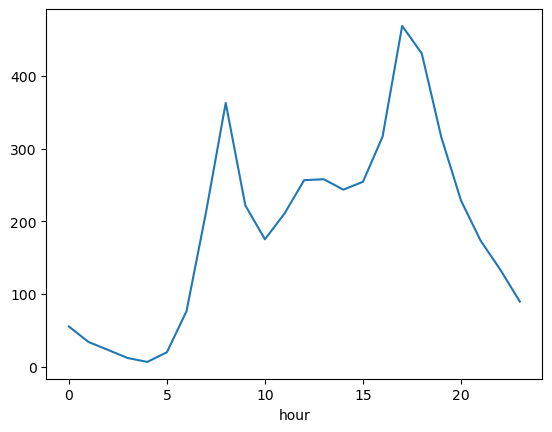

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

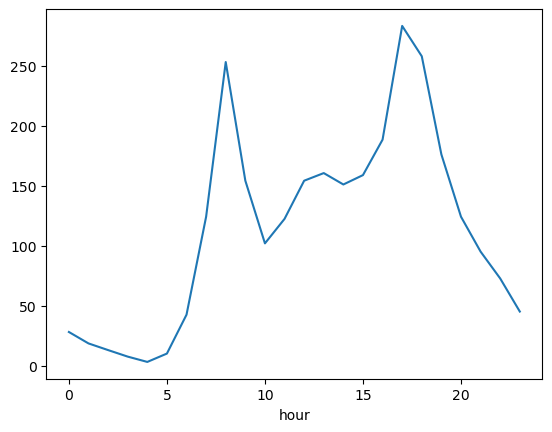

In [9]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes_winter = bikes[bikes['season'] == 1]
bikes_winter.groupby('hour').total.mean().plot()


<Axes: xlabel='hour'>

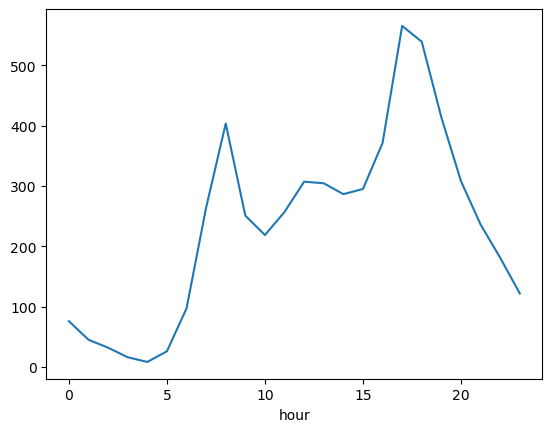

In [10]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes_summer = bikes[bikes['season'] == 3]
bikes_summer.groupby('hour').total.mean().plot()

Para ambas estaciones la grafica es general en la distribucion de horas pico y horas valle, sin embargo se evidencia que en invierno las horas pico (8am y 5pm) el promedio de prestamos es muy similar y en el rango de 250 a 300 prestamos por hora, mientras que en verano la diferencia en las horas pico es mas notable y cerano a 400 prestamos a las 8am y 600 sobre las 5pm. Esto puede indicar que en horario de verano hay otras actividades adicionales al trasporte desde y hacia el trabajo que pueden motivar a las personas a rentar una bicicleta. 

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:
# Celda 3

# Creando variables dummy para 'season'
bikes_encoded = pd.get_dummies(bikes, columns=['season'], drop_first=True)

X = bikes_encoded[['hour', 'season_2', 'season_3', 'season_4']]  # Variables predictoras, no se inluye season 1 para evitar multicolinealidad
y = bikes_encoded['total']  # Variable de respuesta

# Creando y entrenando el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Coeficientes del modelo
coeficientes = model.coef_
intercepto = model.intercept_

# Imprimir los coeficientes y el intercepto del modelo
print("Coeficientes:", coeficientes)
print("Intercepto:", intercepto)


Coeficientes: [ 10.54520609 100.31723192 119.46754995  84.08311787]
Intercepto: -6.430262462305961


El modelo sugiere que la hora del día y la temporada del año son predictores significativos del total de alquileres de bicicletas, con variaciones notables en la demanda según estas dos variables. Las temporadas 2 y 3  muestran un aumento considerable en los alquileres, lo que puede reflejar preferencias estacionales para el uso de bicicletas.

Limitaciones:
1. La regresión lineal asume una relación lineal entre las variables predictoras y la variable de respuesta. Si la relación real entre estas variables es no lineal, el modelo podría no capturar adecuadamente la estructura de los datos.
2. Aunque las variables categóricas se incluyeron con la creación de variables dummy, esto aumenta la complejidad del modelo y requiere que se descarte una de las estaciones, lo cual puede no siempre capturar la naturaleza cíclica o ordenada de las estaciones del año.
3. Al ser un modelo de regresion lineal se asume que los errores son independientes entre sí. En series temporales, como los datos de alquileres de bicicletas, es común que las observaciones estén correlacionadas en el tiempo, violando esta suposición.



### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [ ]:
# Celda 4


<Axes: xlabel='season', ylabel='hour'>

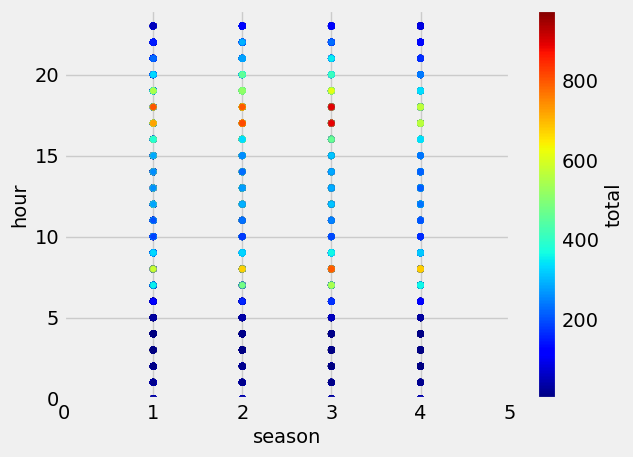

In [32]:
# Gráfica del total, horas y season
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
bikes.plot(kind='scatter', x='season', y='hour', c='total', colormap='jet', xlim=(0, 5), ylim=(0, 24))

In [12]:
# Separación de variables predictoras (X) y variable de interes (y)
X = bikes[['hour', 'season']]
y = bikes[['total']]
X.head()


,hour,season
datetime,,
2011-01-01 00:00:00,0,1
2011-01-01 01:00:00,1,1
2011-01-01 02:00:00,2,1
2011-01-01 03:00:00,3,1
2011-01-01 04:00:00,4,1


In [13]:
y = (bikes.total > 145).astype(int)

In [14]:
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10 #numero de percentiles o rangos
max_features = None
min_gain=0.001

In [52]:
# Impresión variable a usar 
j = 1
print(X.columns[j])

season


In [53]:
# División de la variable season en num_ctp puntos para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([1., 2., 3., 4.])

In [54]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [55]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [56]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [57]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [58]:
# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 0,
 'y_prob': 0.49917340191036,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 0.16178755449047394,
 'sl': {'y_pred': 0,
  'y_prob': 0.0942714126807564,
  'level': 1,
  'split': -1,
  'n_samples': 3594,
  'gain': 0.06425451863089747},
 'sr': {'y_pred': 1,
  'y_prob': 0.6987935289278859,
  'level': 1,
  'split': -1,
  'n_samples': 7292,
  'gain': 0.05853892375774267}}

In [71]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)
tree

{'y_pred': 0,
 'y_prob': 0.49917340191036,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 0.16178755449047394,
 'sl': {'y_pred': 0,
  'y_prob': 0.0942714126807564,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 0.06425451863089747,
  'sl': {'y_pred': 0,
   'y_prob': 0.026106335561922954,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 0.0027878761479700337,
   'sl': {'y_pred': 0,
    'y_prob': 0.010796723752792257,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'gain': 0.0008089140964271449},
   'sr': {'y_pred': 0,
    'y_prob': 0.11816192560175055,
    'level': 3,
    'split': [1, 3.0],
    'n_samples': 455,
    'gain': 0.009214309359181827,
    'sl': {'y_pred': 0,
     'y_prob': 0.05240174672489083,
     'level': 4,
     'split': [1, 2.0],
     'n_samples': 227,
     'gain': 0.004655188204359839,
     'sl': {'y_pred': 0,
      'y_prob': 0.008695652173913044,
      'level': 5,
      'split': -1,
      'n_samples': 1

Realizar predicciones usando el árbol creado

In [72]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [61]:
# Ejecución de función tree_predict
tree_predict(X, tree)

array([0., 0., 0., ..., 1., 0., 0.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [84]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 20)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

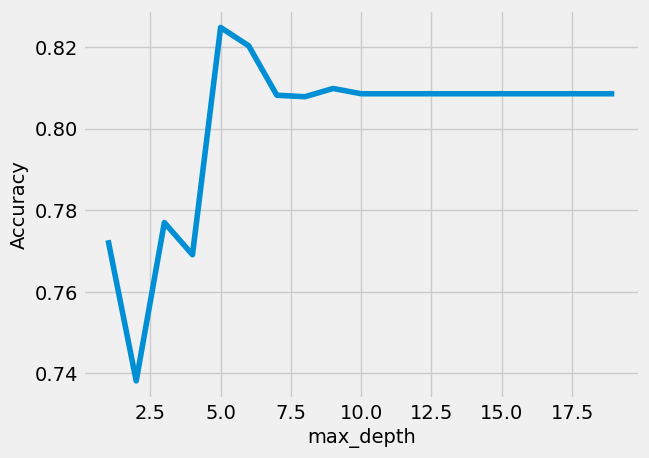

In [85]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [64]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.824853987738346, 5)

In [74]:
# max_depth=5 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=5, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [75]:
feature_cols = X.columns

In [76]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
1,season,0.157761
0,hour,0.842239


La hora del dia es la variable que mas se utiliza para partir el arbol

In [81]:
# Impresión de resultados de desemepeño del árbol de decisión utilizando validacion cruzada
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.824854
std       0.147466
min       0.449036
25%       0.805785
50%       0.883330
75%       0.910386
max       0.947610
dtype: float64

En promedio el arbol esta teniendo un Accuracy del 82,5%

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [8]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [9]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [10]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 6



### ARBOL DE DECISION

In [11]:
#Arbol de decision
model2 = DecisionTreeClassifier()
model2.fit(X_train, y_train)

DecisionTreeClassifier()

In [12]:
y_predDT = model2.predict(X_test)
y_predDT

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [13]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 30)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

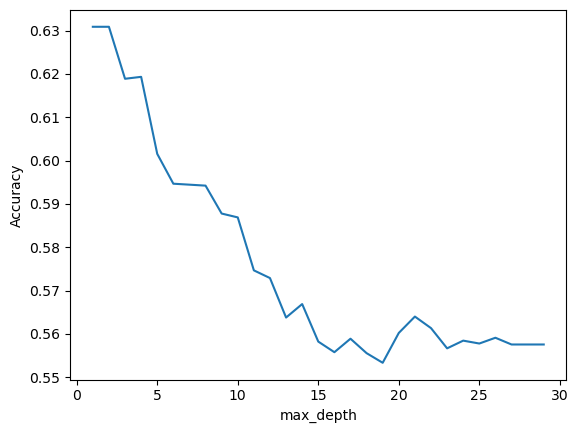

In [7]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [14]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6308888888888888, 2)

In [15]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [16]:
feature_cols = X_train.columns

In [17]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
0,timedelta,0.000000
31,weekday_is_tuesday,0.000000
32,weekday_is_wednesday,0.000000
33,weekday_is_thursday,0.000000
34,weekday_is_friday,0.000000
35,weekday_is_saturday,0.000000
36,weekday_is_sunday,0.000000
37,is_weekend,0.000000
38,LDA_00,0.000000
39,LDA_01,0.000000


In [18]:
from sklearn.metrics import accuracy_score, f1_score

In [19]:
y_pred = clf.predict(X_test)
y_pred 

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6453333333333333


In [28]:
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

F1-Score: 0.6448598130841121


### REGRESION LOGISTICA

In [21]:
#Regresion logistica
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [22]:
y_predLR = model.predict(X_test)
y_predLR

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [23]:
accuracy = accuracy_score(y_test, y_predLR)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6146666666666667


In [24]:
f1 = f1_score(y_test, y_predLR)
print(f"F1-Score: {f1}")

F1-Score: 0.6110363391655451


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [25]:
# Celda 7
# Impresión datos
X.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,2.0,...,0.470000,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8
1,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,0.0,...,0.342778,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1
2,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,0.0,...,0.516263,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0
3,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,0.0,...,0.436654,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0
4,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,0.0,...,0.346429,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0


In [26]:
# Proporciones de las diferentes clases de variable de interés (y)
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
1,3000,0.5
0,3000,0.5


In [27]:
#  Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [28]:
# Creación de 300 muestras de bootstrap
n_estimators = 300
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [29]:


np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators) #SEMILLA para inicializar CADA árbol de decisión

trees = {}
   
for i in range(n_estimators):
    # Primeras 100 muestras: Árboles de decisión con max_depth específico
    if i < 100:
        trees[i] = DecisionTreeClassifier( max_depth=2, random_state=seeds[i]) 
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    # Siguientes 100 muestras: Árboles de decisión con min_samples_leaf específico
    elif i < 200:
        trees[i] = DecisionTreeClassifier( min_samples_leaf=4, max_depth=None, random_state=seeds[i])  
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    # Últimas 100 muestras: Regresiones logísticas
    else:
        trees[i] = LogisticRegression(random_state=seeds[i])
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
        


In [30]:
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1782,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3917,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
221,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5224,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Impresión de la cantidad de modelos que predijeron 1 para 10 observaciones
y_pred_df.sum(axis=1)[:]

1782     56
3917    177
221      50
2135      7
5224     18
       ... 
2522     81
312      47
5887    159
4483    287
2647     33
Length: 1980, dtype: int64

In [32]:
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
metrics.f1_score(y_pred, y_test)

0.6320123520329387

In [33]:
# Desempeño al hacer votación mayoritaria
metrics.accuracy_score(y_pred, y_test)

0.6388888888888888

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [34]:
# Celda 8
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

In [35]:
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

Text(0.5, 1.0, 'OOB error of each tree')

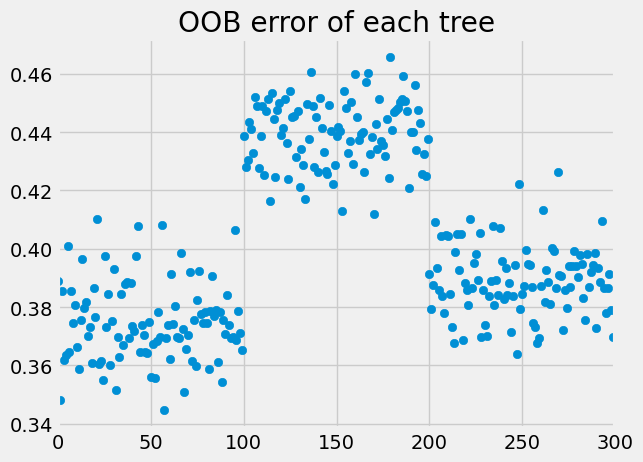

In [36]:
# Visualización de OOB para cada árbol
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree')

In [37]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

In [38]:
# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum_1.head(20)

1782    0.177559
3917    0.598483
221     0.158809
2135    0.021497
5224    0.056629
1168    0.087453
879     0.053051
156     0.037799
1657    0.838643
323     0.074251
5302    0.454460
2611    0.135642
811     0.112773
393     0.905680
3593    0.118760
2638    0.822120
2187    0.861288
5351    0.136966
319     0.031424
167     0.943887
dtype: float64

In [39]:
# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6326635754765586, 0.6398989898989899)

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

#Votacion mayoritaria
F1 Score 0.6320123520329387
Accuracy 0.6388888888888888

#Votacion ponderada
F1 Score 0.6326635754765586
Accuracy 0.6398989898989899

Los resultados indican que tanto la votación mayoritaria como la votación ponderada ofrecen desempeños similares en términos de F1 Score y Accuracy, con una leve mejora en la votación ponderada.
La pequeña diferencia entre los dos métodos de votación implica que el rendimiento de los modelos en el ensamble es bastante uniforme, y que ajustar los pesos basados en el error OOB no ofrece una ventaja significativa.Si embargo, como se ve en el grafico de OOB, los modelo 1 y 3 tienen errores menores que el modelo 2, esto hace que aunque sea pequeña, si exista una diferencia entre los dos tipos de votaciones.
En este caso, aunque la votacion mayoritaria es mas simple, no aprovecha completamente el potencial de los modelos idividuales mas fuertes. Como en este caso los modelos individuales tienen desempeño muy similar la diferencia de resultados no es muy grande, pero en definitiva si es una opcion para explorar mejores resultados. 